In [1]:
import os
import numpy as np
import librosa
import random

# DATA PROCESSING
DATASET_PATH = "/home/gmallet/datasets/gtzan"
ROI_PATH = DATASET_PATH + "/genres_original/"

TIME_SERIES_LENGTH = 128
HOP_LENGTH = 512
CATEGORIES = os.listdir(ROI_PATH)

# AUDIO SAMPLING RATE
sr = 22050
SONG_DURATION = 29
# TOTAL NB SAMPLE OF EACH SONG
TOTAL_SAMPLES = SONG_DURATION * sr
# NB SLICE PER SONG
NB_SLICES = 10
# HOW MANY SAMPLE IS NEEDED TO MAKE A SLICE
SAMPLES_PER_SLICE = int(TOTAL_SAMPLES / NB_SLICES)

def get_files(root_path, extension):
    files_paths = []
    for root, _, files in os.walk(root_path, topdown=True):
        files_paths += [os.path.join(root, file) for file in files if file.endswith(extension)]
    return files_paths

# USE ALL POSSIBLE SAMPLE PER SONG
# DECIDED TO GO WITH MFCC TO EXTRACT FEATURES FROM SONG.
# THE FIRST REASON I CHOOSE MFCC IS BECAUSE OF HIS POPULARITY, PRETTY MUCH EVERY AUDIO
# CLASSIFICATION USE IT. THE SECOND IS BY FINDING HOW MFCC GLOBALLY WORKS, BY SCALING FREQUENCIES
# TO MEL SCALE, WHICH 'SIMULATE' THE WAY HUMAN EARS WORKS USING A LOG SCALE SINCE FOR A HUMAN,
# THE DIFFERENCE BTW 1KhZ and 2KhZ THAN BTW 4KhZ AND 5KhZ. THE MOST IMPORTANT FOR HUMAN EARS IS THE RATE OF
# CHANGE, NOT THE ABSOLUTE DIFFERENCE BTW 2 FREQUENCIES.
def extract_audio_features(files_paths):
    labels = []
    features = []
    for i, file_path in enumerate(files_paths):
        song, sr = librosa.load(file_path, duration=SONG_DURATION)
        genre = file_path.split("/")[-2]
        index = CATEGORIES.index(genre)
        for s in range(NB_SLICES):
            start_sample = SAMPLES_PER_SLICE * s
            end_sample = start_sample + SAMPLES_PER_SLICE
            mfcc = librosa.feature.mfcc(y=song[start_sample:end_sample], sr=sr, n_mfcc=13)
            mfcc = mfcc.T
            labels.append(index)
            features.append(mfcc.tolist())
        print(
            "\rExtracted features audio track %i of %i."
            % (i+1, len(files_paths)), end=''
        )
    print()
    return (np.array(features), np.array(labels))


# USE ONLY ONE SAMPLE PER SONG, AND STILL MFCC ON THE WHOLE SONG SO REALLY BAD
def bad_extract_audio_features(files_paths):
    nb_files = len(files_paths)
    
    features = np.zeros(
        (nb_files, TIME_SERIES_LENGTH, 13), dtype=np.float64
    )
    
    
    labels = np.zeros(
        (nb_files, 1), dtype=np.int32
     )
    
    for i, file in enumerate(files_paths):
        y, sr = librosa.load(file)
        mfcc = librosa.feature.mfcc(
            y=y, sr=sr, hop_length=HOP_LENGTH, n_mfcc=13
        )
            
        genre = file.split("/")[-2]
        index = CATEGORIES.index(genre)
        
        labels[i][0] = index 
        features[i, :] = mfcc.T[0:TIME_SERIES_LENGTH, :]
        print(
            "\rExtracted features audio track %i of %i."
            % (i+1, nb_files), end=''
        )
    print()
    return (features, labels)



def load_data(files_path):
    files_paths = get_files(files_path, "wav")
    random.shuffle(files_paths)
    a, b = int(len(files_paths) * 0.8), int(len(files_paths) * 0.9)
    train_fp, val_fp, test_fp = files_paths[:a], files_paths[a:b], files_paths[b:]

    # SHOULD SAVE THIS TO JSON OR SMTHG
    return {
        "train": extract_audio_features(train_fp),
        "validate": extract_audio_features(val_fp),
        "test": extract_audio_features(test_fp),
    }

dataset = load_data(ROI_PATH)

Extracted features audio track 799 of 799.
Extracted features audio track 100 of 100.
Extracted features audio track 100 of 100.


In [12]:
dataset["train"][0].shape
# (7990, 125, 13)

(7990, 125, 13)

In [13]:
# MODEL
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers import Dense, TimeDistributed
from keras.losses import SparseCategoricalCrossentropy

# FIRST INTUITION THOUGH MUSIC IS SORT OF A TIME SERIES, AND RNNs ARE SUPPOSED TO BE MADE FOR THIS.
# EVEN THO SAW A LOT OF CNN PERFORM A LOT BETTER THAN EVERY RNN ON THIS DATASET, DON'T HAVE MUCH EXPLANATION HERE,
# STILL DECIDED TO WORK WITH RNN SINCE NEVER DONE ANY.
# BIT OF SEARCH ON THE SUBJET THAUGH ME THAT RNNs WHEREN'T THE WAY TO GO UNLESS YOU REALLY KNOW WHAT YOUR DOING,
# BECAUSE OF VANISHING GRADIENT PROBLEM, SO DECIDED TO GO FOR LSTM.
def get_model(input_shape, output_size):
    model = Sequential()
    model.add(LSTM(units=128, dropout=0.05, recurrent_dropout=0.35, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units=32,  dropout=0.05, recurrent_dropout=0.35, return_sequences=False))
    # TRY WITH TimeDistributed LAYERS
    model.add(Dense(units=output_size, activation="softmax"))

    model.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=["accuracy"])
    model.summary()
    return model

In [21]:
# TRAINING
# I DON'T HAVE MUCH TO SAY ON THESE 2 PARAMETERS, TRYED DIFFERENTS ONE RANDOMLY, THESE WERE WORKING WELL, 
# EVEN THOUGH BATCH_SIZE IS MAYBE A BIT TOO BIG, SO TRAINING TAKE A LOT OF TIME.
BATCH_SIZE = 60
NUM_EPOCHS = 40

def train(dataset):
    input_shape = (dataset["test"][0].shape[1], dataset["test"][0].shape[2])
    model = get_model(input_shape, 10)
    return model, model.fit(
        dataset["train"][0],
        dataset["train"][1],
        validation_data=dataset["validate"],
        batch_size=BATCH_SIZE,
        epochs=NUM_EPOCHS,
        shuffle=True
    )

In [22]:
# VISUALIZATION
import matplotlib.pyplot as plt

def show_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(NUM_EPOCHS)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()


In [23]:
model, history = train(dataset)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 125, 128)          72704     
                                                                 
 lstm_7 (LSTM)               (None, 32)                20608     
                                                                 
 dense_3 (Dense)             (None, 10)                330       
                                                                 
Total params: 93,642
Trainable params: 93,642
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
134/134 [==============================] - 37s 239ms/step - loss: 1.7730 - accuracy: 0.3890 - val_loss: 1.5657 - val_accuracy: 0.4340
Epoch 2/40
134/134 [==============================] - 32s 242ms/step - loss: 1.4639 - accuracy: 0.4762 - val_loss: 1.4915 - val_accuracy: 0.4500
Epoch 3/40
134/134 [====

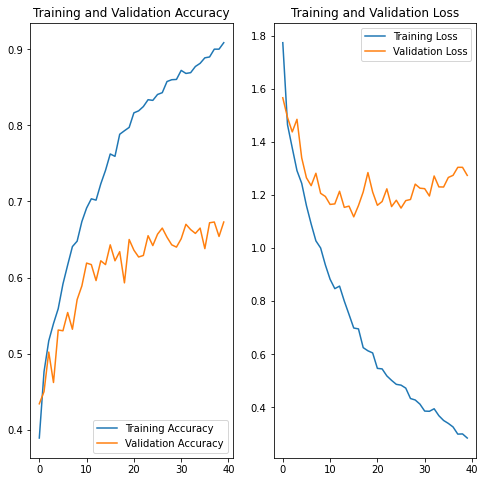

In [24]:
show_history(history)
# WE CAN SEE HERE THAT OUR MODEL LEARNING CORRECTLY.
# IT FEELS LIKE MODEL IS OVERFITTING APPROXIMATELY FROM EPOCH 20.

In [25]:
# EVALUATION
model.evaluate(
    dataset["test"][0], dataset["test"][1], batch_size=20, verbose=1
)

50/50 [==============================] - 2s 23ms/step - loss: 0.9697 - accuracy: 0.7020


[0.9697200655937195, 0.7020000219345093]

In [26]:
BATCH_SIZE = 60
NUM_EPOCHS = 20
model, history = train(dataset)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 125, 128)          72704     
                                                                 
 lstm_9 (LSTM)               (None, 32)                20608     
                                                                 
 dense_4 (Dense)             (None, 10)                330       
                                                                 
Total params: 93,642
Trainable params: 93,642
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
134/134 [==============================] - 37s 236ms/step - loss: 1.7638 - accuracy: 0.3770 - val_loss: 1.5356 - val_accuracy: 0.4330
Epoch 2/20
134/134 [==============================] - 31s 230ms/step - loss: 1.4630 - accuracy: 0.4751 - val_loss: 1.5767 - val_accuracy: 0.4490
Epoch 3/20
134/134 [====

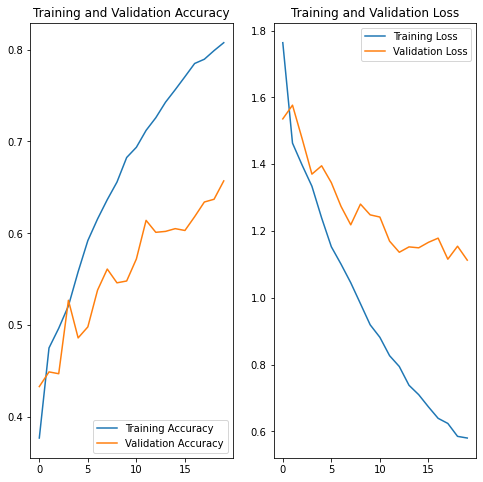

In [27]:
show_history(history)
# NICE! NO OVERFIT

In [28]:
# EVALUATION
model.evaluate(
    dataset["test"][0], dataset["test"][1], batch_size=20, verbose=1
)
# MODEL IS PRETTY ACCURATE, THAT'S COOL

50/50 [==============================] - 1s 22ms/step - loss: 0.9579 - accuracy: 0.6930


[0.9579042792320251, 0.6930000185966492]

In [29]:
# SAVING MODEL
model.save("./models/rnn_gtzan_mfcc")

2022-03-31 03:17:37.811749: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./models/rnn_gtzan_mfcc/assets
